# Beer Production Time Series Analysis

This notebook explores **monthly beer production data** using time series analysis.  
We will visualize the series, check variance, and perform decomposition to extract **trend, seasonal, and residual components**.


In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Optional for nicer plots
import seaborn as sns
sns.set_style('whitegrid')


## Load the Dataset

We load the beer production dataset and take a first look at its structure.  
The goal is to ensure the time index is correctly set and there are no missing values.


In [8]:
import pandas as pd

# Use raw string (r"") to handle backslashes in Windows
beer_data = pd.read_csv(r"C:\Users\use\Documents\data.csv", parse_dates=['Month'], index_col='Month')

# Quick check
beer_data.head()
#beer_data.info()


,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


## Plot the Raw Time Series

Visualizing the series helps us identify **trends, seasonality, and anomalies** before any analysis.


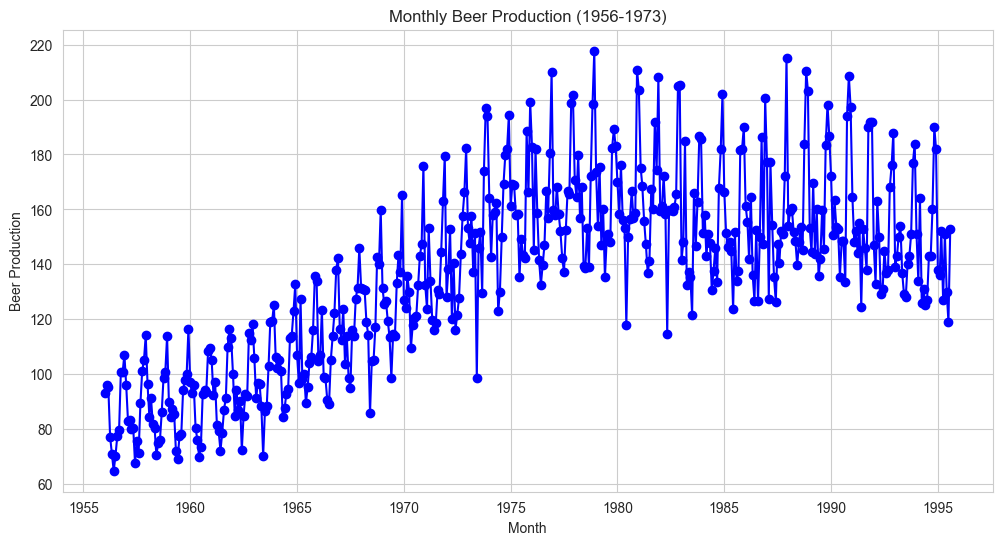

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for nicer plots
sns.set_style('whitegrid')

# Plot the raw time series
plt.figure(figsize=(12,6))
plt.plot(beer_data, marker='o', color='blue')
plt.title('Monthly Beer Production (1956-1973)')
plt.xlabel('Month')
plt.ylabel('Beer Production')
plt.show()


### (a) Trend and Seasonal Components

From the time plot of the Monthly Beer Production series, we observe the following:

- **Trend:**  
  There is a clear upward trend from the mid-1950s to the late-1970s, indicating a steady increase in beer production over time. After this period, the series appears to stabilize and fluctuate around a higher level, with slight variations in later years.

- **Seasonality:**  
  The series shows a strong and regular seasonal pattern. Peaks and troughs repeat approximately every 12 months, which is typical for monthly data. This indicates the presence of an annual seasonal component.

- **Irregular Component:**  
  Random fluctuations are present around both the trend and seasonal patterns, representing short-term variations that cannot be explained by the main structure of the series.

---




## Check Variance and Decide Decomposition Model
“Variance measures how much the values of a series fluctuate around the average over time.”
- Are the ups and downs roughly the same throughout the series? → constant variance

- Do the fluctuations increase or decrease as the series grows? → changing variance

Before decomposition, we need to check if the **variance of the series is constant** over time:

- **Constant variance → Additive model**  
- **Variance grows with the level → Multiplicative model**  

We can visualize this by plotting the series normally and optionally with a **log transformation**.


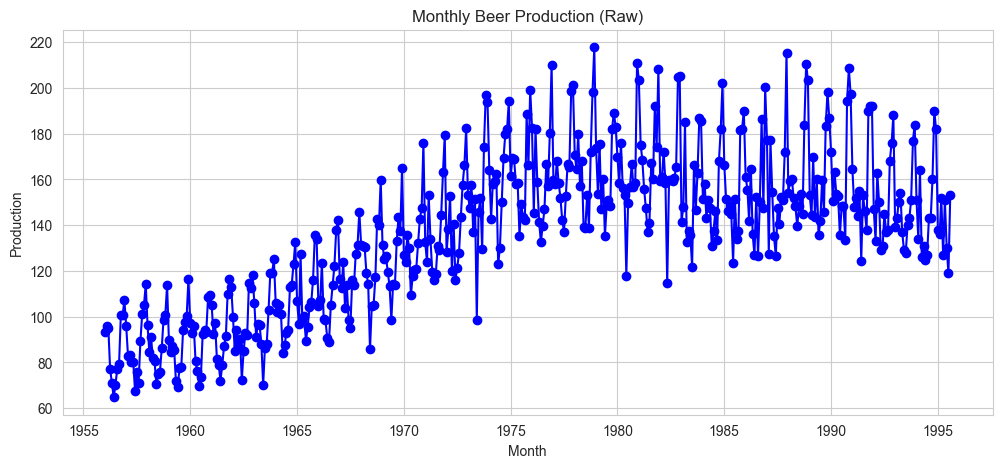

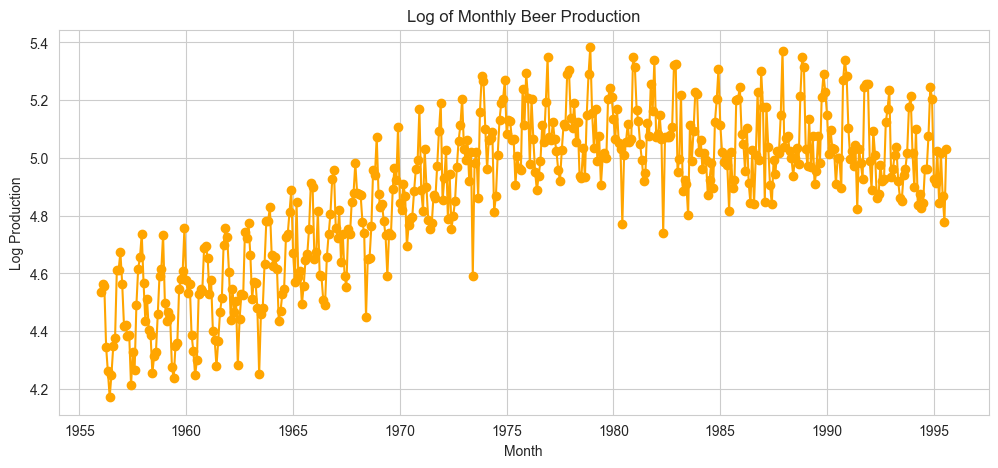

In [10]:
import numpy as np

# Plot raw series
plt.figure(figsize=(12,5))
plt.plot(beer_data, marker='o', color='blue')
plt.title('Monthly Beer Production (Raw)')
plt.xlabel('Month')
plt.ylabel('Production')
plt.show()

# Plot log-transformed series to check multiplicative behavior
plt.figure(figsize=(12,5))
plt.plot(np.log(beer_data), marker='o', color='orange')
plt.title('Log of Monthly Beer Production')
plt.xlabel('Month')
plt.ylabel('Log Production')
plt.show()


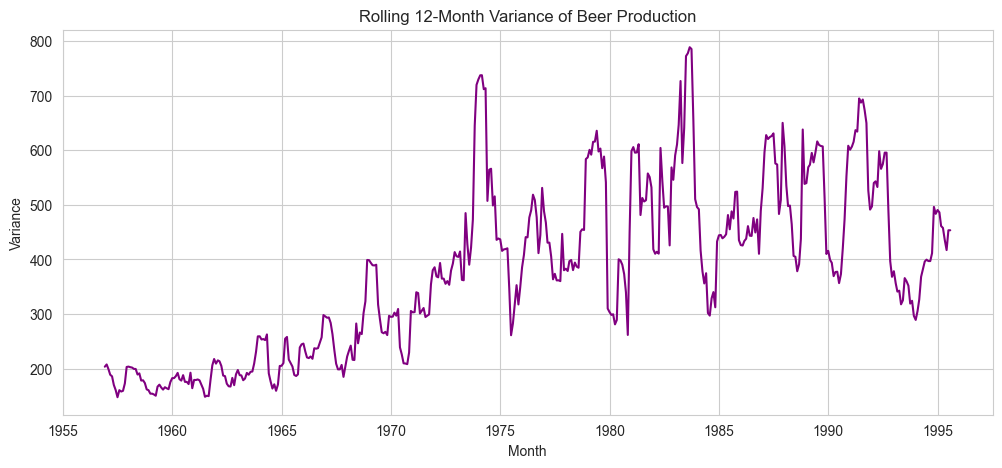

Coefficient of Variation: 0.247


In [12]:
# Rolling variance with 12-month window
rolling_var = beer_data.rolling(window=12).var()

# Plot it
plt.figure(figsize=(12,5))
plt.plot(rolling_var, color='purple')
plt.title('Rolling 12-Month Variance of Beer Production')
plt.xlabel('Month')
plt.ylabel('Variance')
plt.show()
cv = beer_data.std() / beer_data.mean()
print(f'Coefficient of Variation: {cv.values[0]:.3f}')


### Choice of Decomposition Model: Multiplicative

To determine whether an additive or multiplicative decomposition is appropriate, we examined the **variance structure** of the beer production series:

- In the early years, production levels are low and seasonal fluctuations are relatively small.  
- As the overall production increases, the magnitude of seasonal peaks and troughs grows.  
- This indicates that the **variance of the series increases with the mean level**, meaning the seasonal effect is **proportional to the level of the series** rather than constant.

**Quantitative check:**  
- Coefficient of Variation (CV) = 0.247, showing moderate relative variability.  
- Rolling variance analysis also confirms that fluctuations grow slightly as the series level increases.

**Conclusion:**  
> Because the seasonal fluctuations increase with the level of production, a **multiplicative decomposition model** is more appropriate than an additive one.

Mathematically, the multiplicative decomposition is expressed as:

\[
Y_t = T_t \times S_t \times R_t
\]

Where:  
- \(Y_t\) = observed value  
- \(T_t\) = trend component  
- \(S_t\) = seasonal component  
- \(R_t\) = residual component


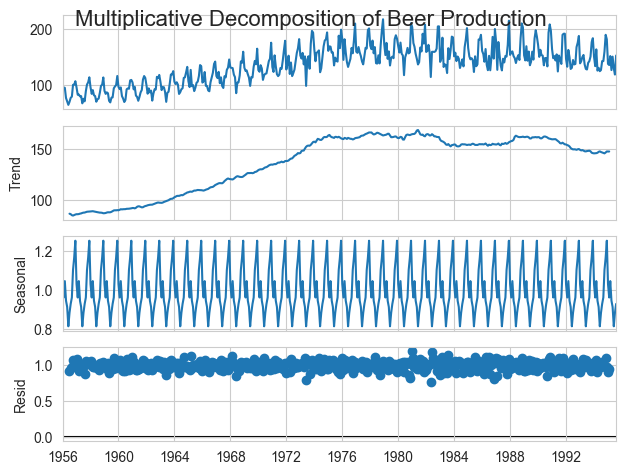

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply multiplicative decomposition
decomp_mult = seasonal_decompose(beer_data, model='multiplicative', period=12)
# Plot all components together
decomp_mult.plot()
plt.suptitle('Multiplicative Decomposition of Beer Production', fontsize=16)
plt.show()


### Time Series Decomposition of Monthly Beer Production

This plot is a time series decomposition of monthly beer production data. It splits the series into **trend**, **seasonal**, and **residual** components. Let’s interpret each panel carefully:

---

### Top Panel – Original Series (Monthly Beer Production)

- Shows the actual beer production over time.
- We can see an overall upward trend until roughly the middle, then it flattens or slightly declines toward the end.
- Clear seasonal fluctuations (repeating peaks and troughs each year), likely reflecting higher production in certain months.

---

### Second Panel – Trend

- Isolates the long-term movement in production.
- Beer production rises steadily until around month 200–250, peaks, and then slightly declines or stabilizes afterward.
- Suggests growth followed by plateauing.

---

### Third Panel – Seasonal

- Captures repeating monthly patterns.
- Peaks and troughs are consistent across years, indicating a strong seasonal effect.
- For example, there may be higher production in summer months and lower in winter months (common for beer consumption).

---

### Bottom Panel – Residual (Noise)

- Shows what’s left after removing trend and seasonality.
- Residuals are roughly around 1, indicating **multiplicative decomposition** (since the seasonal effect multiplies the trend).
- There is no obvious pattern, suggesting that the model has captured most of the systematic behavior.

---

### Summary

- Beer production shows seasonal increases and decreases every year.
- There is a long-term growth trend, followed by a stabilization.
- The residuals are fairly stable, indicating the decomposition model fits well.



## Autocorrelation and Partial Autocorrelation of Residuals

After decomposition, the residual component should ideally be **random noise**.  
We can check this by plotting:

- **ACF (Autocorrelation Function):** measures correlation of the residuals with their past values at different lags.  
- **PACF (Partial Autocorrelation Function):** measures correlation with a lag after removing the effect of intermediate lags.  

Patterns in these plots indicate whether any structure remains in the residuals.


<Figure size 1200x400 with 0 Axes>

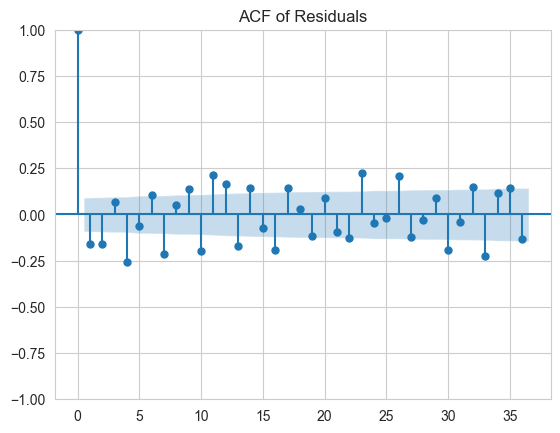

<Figure size 1200x400 with 0 Axes>

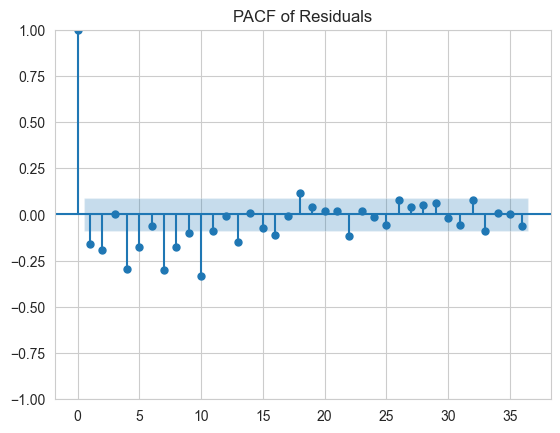

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Drop NaN values from residuals
residuals = decomp_mult.resid.dropna()

# Plot ACF
plt.figure(figsize=(12,4))
plot_acf(residuals, lags=36)
plt.title('ACF of Residuals')
plt.show()

# Plot PACF
plt.figure(figsize=(12,4))
plot_pacf(residuals, lags=36)
plt.title('PACF of Residuals')
plt.show()
